## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [166]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [167]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_named' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (953, 5)


serum table has 36 samples and 1071 metabolites

In [168]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)

muscle_chemicals.to_csv('muscle_chemicals.csv')
serum_chemicals.to_csv('serum_chemicals.csv')


In [169]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != '2HB']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != '2HB']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS == 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 620) 
 (24, 953)


In [170]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [171]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 3 rows in serum file and 6 in muscle


In [172]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))

samples_2HB = muscle_samples[muscle_samples.DRUG2 != '2HB'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
samples_2HB = serum_samples[serum_samples.DRUG2 != '2HB'].set_index('PARENT_SAMPLE_NAME')
serum_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_na['Tx'] = serum_na.Group.str[0]
serum_na['Ex'] = serum_na.Group.str[1]



/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/4038708954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/4038708954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na['Tx'] = muscle_na.Group.str[0]
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/4038708954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [173]:
# impute based on group values

def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).median())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Group')
serum_na = impute_by_group(serum_na,'Group')


In [174]:
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns = df.select_dtypes(include=object)
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.drop(object_columns.columns,axis=1).fillna(df.min(axis=0))

    if scale_by == 1:
        df = df.div(df.median())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
        df = pd.merge(left=df,right=object_columns,how='left',left_index=True,right_index=True) # add back object columns
    return df



In [175]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,0,1)
serum_med = met_transform(serum_na,1,0,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [176]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method

    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns1 = df1.select_dtypes(include=object)
    object_columns2 = df2.select_dtypes(include=object)
    df1 = df1.drop(object_columns1.columns,axis=1)
    df2 = df2.drop(object_columns2.columns,axis=1)

    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    # object columns are the same between the two, since we are just testing different normalization methods, so only add back one of the object columns
    df_fwn = pd.merge(left = df_fwn, right = object_columns1, how='left',left_index=True,right_index=True) # add back object columns
    return df_fwn


In [177]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.4389312977099237 
 The proportion of normally distributed columns with method_2 is: 0.7786259541984732
take 115 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.5773447015834349 
 The proportion of normally distributed columns with method_2 is: 0.7929354445797807
take 297 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [178]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [179]:
# add VO2 columns matching by index
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,DiHOME,oxoadipate,Nformylmethionine,methylthioadenosineMTA,adenosinediphosphoriboseADPribose,aspartate,hydroxyphenyllactateHPLA,cholesterol,creatinine,gammaglutamylglutamate,...,ditertbutylphenol,oleylGPCO,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,0.608347,1.042207,-0.193984,0.898549,-0.054543,0.541567,0.397357,0.977082,-0.417166,0.344146,...,-0.309996,0.374902,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VR60,1.643727,1.051906,0.946843,-0.703095,0.548383,0.587715,0.487800,-0.152494,-0.015103,-0.622314,...,0.253395,-0.560278,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VR83,0.608347,1.663761,0.688712,0.275956,-0.105051,1.173961,1.963020,0.377736,-0.476015,-0.226220,...,-1.683441,2.166159,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155
VR42,0.608347,0.515846,0.692837,-1.242110,0.147490,1.226141,-0.168356,-0.086384,0.447860,0.829830,...,-0.019804,0.431593,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
VR72,0.608347,-0.213895,0.038473,0.267316,1.631457,-0.523563,0.359373,-0.581542,-2.222739,-0.728907,...,1.454636,-0.257130,VR,V,R,0.582898,0.616650,0.643768,1.028224,1.079038


In [180]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,putrescine,methylnicotinamide,hypoxanthine,NNNtrimethyllysine,methylthioadenosineMTA,ribosephosphate,arginine,argininosuccinate,hydroxyphenyllactateHPLA,betaalanine,...,oxindolylalanine,oleylGPCO,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,0.473421,0.281887,-0.248016,1.099835,-0.653174,-1.363658,-1.069613,-1.117955,0.173949,1.123712,...,0.789719,1.638250,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VR42,-0.143856,0.188509,0.828502,0.388485,0.438711,-0.226439,0.110292,-0.614733,-0.540484,0.396887,...,-0.110649,0.819979,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
VR60,0.212720,-0.821858,1.403593,0.303636,0.812450,-0.507970,1.378200,0.054859,1.185126,0.344938,...,0.660689,1.053641,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VR72,0.249180,-0.622455,-0.745786,0.597527,0.188728,0.225342,-0.707640,0.015481,0.451142,0.119094,...,-0.583811,0.651270,VR,V,R,0.582898,0.616650,0.643768,1.028224,1.079038
VR83,0.433651,-0.600980,-0.421565,0.376440,0.686430,1.015940,-1.256517,-1.273325,-0.338414,2.071038,...,-0.068872,0.218323,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155


In [181]:
# save data files as csv for other uses
serum_fwn.to_csv('serum_fwn.csv')
muscle_fwn.to_csv('muscle_fwn.csv')

In [182]:
# conduct basic differential abundance analysis
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import seaborn as sns
from pingouin import ancova

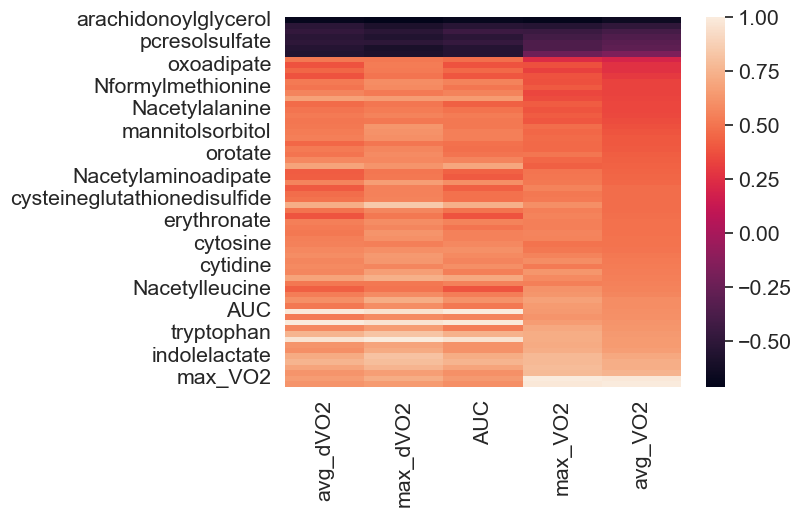

In [183]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

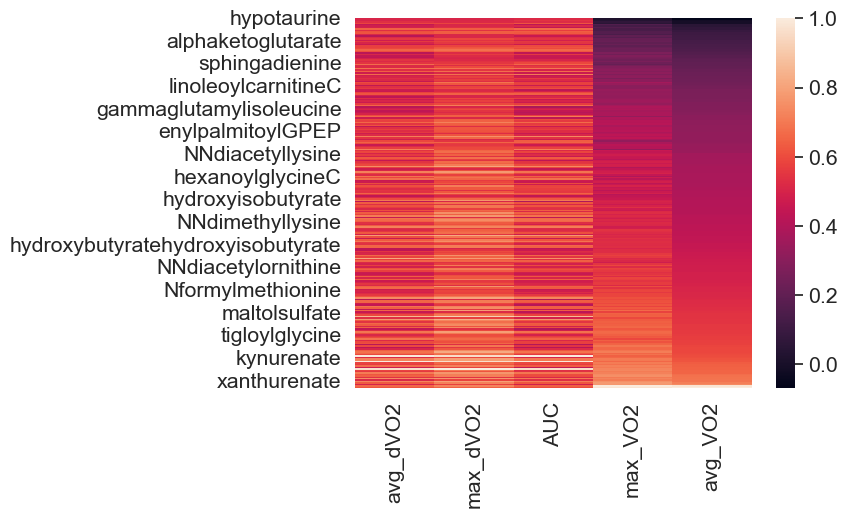

In [184]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

## Serum linear model and adjusting means for exercise

*** Conceptualizing linear adjustment for covariates
- Imagine that we want to compare blood pressure in two different cities, but the individuals in each city are different ages
- We know that blood pressure is affected by age, and we are going ot assume in a linear fashion
- We want to convert the blood pressure values to age-adjusted-blood pressure, that is, what the blood pressure would be in each individual adjusting for the age covariate
- We run a linear model (bp ~ age)
- How high or low someones blood pressure is after adjustment for age is the residual value, i.e. the distance from the data-point to the linear regression model, plus the intercept value.
    - The intercept value gives a baseline blood pressure, e.g. 100, and the residual gives the value difference.

In [185]:
grouped = serum_fwn.groupby('Tx') # organize data by Tx
serum_adj = pd.DataFrame(columns=serum_fwn.columns) # frame for holding adjusted values
covars=['avg_dVO2','avg_VO2']

for met in serum_fwn.columns[:-8]:
    # print(met) # for tracking progress in loop
    # C(Group) tells the model to expect a categorical variable

#    model = ols(formula=f'{met} ~ {covars[0]} + {covars[1]}', data = serum_fwn).fit()
#   serum_adj[met] = model.resid + model.params[0]

     model = ols(formula=f'{met} ~ {covars[1]}', data=grouped.get_group('V')).fit()
     hb_adj = grouped.get_group('G')[met] - model.predict(grouped.get_group('G')) + model.params[0]
     veh_adj = model.resid + model.params[0]
     serum_adj[met] = pd.concat([hb_adj,veh_adj],axis=0)

serum_adj['Group'] = serum_fwn['Group']
serum_adj['Tx'] = serum_fwn['Tx']
serum_adj['Ex'] = serum_fwn['Ex']
serum_adj['avg_VO2'] = serum_fwn['avg_VO2']
serum_adj['avg_dVO2'] = serum_fwn['avg_dVO2']
serum_adj = serum_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
serum_adj.to_csv('serum_adjusted_values.csv')


In [186]:
serum_adj.head(10)

,putrescine,methylnicotinamide,hypoxanthine,NNNtrimethyllysine,methylthioadenosineMTA,ribosephosphate,arginine,argininosuccinate,hydroxyphenyllactateHPLA,betaalanine,...,ditertbutylphenol,cismethyleneheptanoylglycine,NNdimethylpropro,oxindolylalanine,oleylGPCO,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
GR30,-0.256660,0.619021,0.119887,1.772717,-0.058021,-1.070584,1.084129,1.939103,0.843722,-0.649345,...,1.070758,0.393838,-0.212171,1.452860,1.737631,GR,G,R,0.511608,-0.485127
GR50,2.279631,-0.202115,0.593944,1.989116,1.861343,-1.062292,0.329624,1.923014,1.076395,1.334235,...,0.384541,-0.394151,1.574567,2.387550,0.947438,GR,G,R,1.249844,0.560510
GR62,0.361339,1.571175,1.251239,0.196903,1.543293,0.116317,0.756341,0.653028,1.920137,0.538391,...,0.321867,-0.873515,0.555823,1.173592,0.935482,GR,G,R,1.780725,0.295528
GR74,1.352481,-0.338887,0.064134,1.248838,1.605078,0.442846,0.074404,1.216512,-0.211514,0.482766,...,-0.010623,1.479868,1.307279,-0.433802,-0.396517,GR,G,R,2.135189,1.179209
GR90,1.579510,-2.295900,0.533469,-0.169094,0.019621,1.277936,1.248717,0.279714,-0.115657,-0.051166,...,0.333756,0.728376,-0.437542,-0.110038,0.292290,GR,G,R,0.117441,0.394007
GR101,1.095856,-1.402575,1.011919,-1.428881,-1.203978,0.136459,1.342373,-0.060788,-0.302486,-1.325585,...,-0.852403,0.692114,-0.508414,-0.408124,-1.029409,GR,G,R,2.275489,1.638070
GS32,-1.904131,-0.808449,-1.626096,-1.388525,-1.798032,-1.289212,-1.585688,-0.370678,-1.702265,-1.456488,...,-1.507155,-2.193833,-2.129903,-0.813794,-1.151254,GS,G,S,-1.119941,-0.435983
GS51,1.177829,0.679682,-0.151492,0.721753,1.546006,-0.383260,0.960217,0.966427,0.598479,2.371357,...,0.770827,0.348463,1.391916,0.049897,0.348883,GS,G,S,-1.119941,-0.698975
GS63,-0.156478,0.707460,-0.595835,0.415848,0.060946,2.354217,-0.348474,-0.757371,0.328735,0.936657,...,0.981932,0.435239,-0.396008,-0.822218,-0.993768,GS,G,S,-1.119941,-2.503143


### Serum group comparisons

In [187]:
""" ancova
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in serum_adj.columns[:-8]:
    ancova_res = ancova(data=serum_fwn, dv = met, covar = 'avg_VO2', between = 'Tx')
    p_value = ancova_res.iloc[0,4]
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('serum_FDR.csv')
ser_hit_results = results.sort_values('p_value').head(50)
serum_fwn_DE = serum_fwn[ser_hit_results.Metabolite.unique()]
serum_DE = serum_adj[ser_hit_results.Metabolite.unique()]
serum_DE['Group'] = serum_adj['Group']
serum_fwn_DE['Group'] = serum_adj['Group']
print(results.reject.value_counts(),'\n',serum_adj.shape, serum_DE.shape)
"""


" ancova\nresults = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results\n# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe\nfor met in serum_adj.columns[:-8]:\n    ancova_res = ancova(data=serum_fwn, dv = met, covar = 'avg_VO2', between = 'Tx')\n    p_value = ancova_res.iloc[0,4]\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'R'\n        })\nreject, adj_pvalues, sidak, bonf = multipletests(\n    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'\n)\nresults['adj_p'] = adj_pvalues\nresults['reject'] = reject\nresults.to_csv('serum_FDR.csv')\nser_hit_results = results.sort_values('p_value').head(50)\nserum_fwn_DE = serum_fwn[ser_hit_results.Metabolite.unique()]\nserum_DE = serum_adj[ser_hit_results.Metabolite.unique()]\nserum_DE['Group'] = serum_adj['Group']\nserum_fwn_DE['Group'] = serum_adj['Group

In [202]:
grouped = serum_fwn.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in serum_fwn.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    GS = grouped.get_group('GS')[met]
    GR = grouped.get_group('GR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, GR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, GS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('serum_FDR.csv')
ser_hit_results = results.sort_values('p_value').head(50)
serum_DE = serum_fwn[ser_hit_results.Metabolite.unique()]
serum_DE['Group'] = serum_fwn['Group']
print(results.reject.value_counts(),'\n',serum_fwn.shape, serum_DE.shape)

/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VR, GR)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss o

reject
False    1612
True       30
Name: count, dtype: int64 
 (24, 829) (24, 45)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/3674465456.py:32: SettingWithCopyWarning: 
A value

In [203]:
serum_DE.head()


,maltolsulfate,hydroquinonesulfate,neopentylglycolazelate,caproate,allylcatecholsulfate,glycylleucine,stearoylGPG,genistein,daidzein,vanilloylglycine,...,lanthionine,linoleoylarachidonoylGPE,methylthioribose,oleoylGPG,eicosenoylcarnitineC,quinate,glycocholate,xanthine,hydroxyindoleacetate,Group
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,0.062662,-0.230034,0.471872,-0.180467,1.787244,-1.275345,0.964604,1.809672,1.522140,0.884552,...,1.321446,-0.127786,-0.404921,1.580997,-0.663286,0.387705,1.314582,0.495762,1.817587,VR
VR42,1.079437,0.493205,-1.036322,-0.180467,-0.938102,0.159758,0.130348,0.856356,0.406331,-0.640061,...,0.841051,-1.071004,-0.608231,0.437691,-0.041004,-0.780880,-0.759573,0.355942,0.942688,VR
VR60,1.079437,0.493205,-0.235032,-0.180467,1.787244,0.956966,0.419920,0.281163,0.213211,0.558772,...,0.013324,-0.053934,-0.194484,2.357415,0.559069,0.412338,-0.334533,0.652179,0.246227,VR
VR72,-0.511665,-0.028647,-0.516602,-0.581511,1.787244,0.159758,0.130348,0.856356,-0.247824,-1.578568,...,0.429673,-1.124138,0.922129,0.437691,1.023038,0.053538,-0.334533,0.355942,1.011599,VR
VR83,1.693510,1.310191,0.912762,-0.180467,1.787244,-0.637450,-0.159223,0.450925,0.406331,0.558772,...,0.758992,-0.727368,-0.400200,-0.131064,-0.290404,0.927596,-0.334533,0.216122,0.661033,VR


## Muscle Linear model adjusting values for exercise 

In [204]:
muscle_adj = pd.DataFrame(columns=muscle_fwn.columns) # frame for holding adjusted values
covars=['avg_dVO2','avg_VO2','glucosephosphate_ser']
muscle_anc = muscle_fwn.copy()
muscle_anc['glucosephosphate_ser'] = serum_fwn['glucosephosphate']
grouped = muscle_anc.groupby('Tx') # organize data by Tx

for met in muscle_anc.columns[:-9]:
    # print(met) # for tracking progress in loop
    model = ols(formula=f'{met} ~ {covars[0]} + {covars[1]}', data=grouped.get_group('V')).fit()
    # C(Group) tells the model to expect a categorical variable

    hb_adj = grouped.get_group('G')[met] - model.predict(grouped.get_group('G')) + model.params[0]
    veh_adj = model.resid + model.params[0]

    muscle_adj[met] = pd.concat([hb_adj,veh_adj],axis=0)

muscle_adj['Group'] = muscle_fwn['Group']
muscle_adj['Tx'] = muscle_fwn['Tx']
muscle_adj['Ex'] = muscle_fwn['Ex']
muscle_adj['avg_VO2'] = muscle_fwn['avg_VO2']
muscle_adj['avg_dVO2'] = muscle_fwn['avg_dVO2']
muscle_adj = muscle_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
muscle_adj.to_csv('muscle_adjusted_values.csv')


In [205]:
muscle_adj.head()

,DiHOME,oxoadipate,Nformylmethionine,methylthioadenosineMTA,adenosinediphosphoriboseADPribose,aspartate,hydroxyphenyllactateHPLA,cholesterol,creatinine,gammaglutamylglutamate,...,hexanoyltaurine,methylimidazolelactate,Nacetylaminoadipate,ditertbutylphenol,oleylGPCO,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
GR30,-1.063993,1.154451,0.880339,0.413531,0.695610,1.108987,0.799391,-0.545463,0.010543,0.383877,...,1.114908,1.119989,-0.139738,-0.834360,1.012848,GR,G,R,0.511608,-0.485127
GR62,-2.912800,-0.515032,-1.034569,1.032472,-1.580341,-0.674656,-1.162885,0.818661,0.567567,0.577372,...,0.552657,0.519412,-2.025846,-0.847118,-0.170247,GR,G,R,1.780725,0.295528
GR90,-0.167988,1.923113,1.099998,-0.259897,0.678953,0.393547,1.324395,1.762096,-0.309638,-0.228131,...,1.477189,0.660820,0.582321,0.380367,-0.284396,GR,G,R,0.117441,0.394007
GR50,-1.969713,-1.783823,-0.121371,0.607129,-1.096337,-0.386936,-0.129473,-0.261734,1.203700,2.159224,...,-1.445403,-2.431330,0.191693,-0.977384,0.244995,GR,G,R,1.249844,0.560510
GR74,-4.059364,-1.013578,-0.159422,1.402486,0.323271,-2.455290,-0.475490,-0.415491,-0.916178,0.235865,...,-0.152306,0.798238,-2.775814,-0.661476,-1.030151,GR,G,R,2.135189,1.179209


### Muscle group comparisons and testing

In [206]:
"""
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_fwn.columns[:-8]:
    ancova_res = ancova(data=muscle_fwn, dv = met, covar = 'max_VO2', between = 'Tx')
    p_value = ancova_res.iloc[0,4]
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('muscle_FDR.csv')
mus_hit_results = results.sort_values('p_value').head(50)
muscle_DE = muscle_adj[mus_hit_results.Metabolite.unique()]
muscle_fwn_DE = muscle_fwn[mus_hit_results.Metabolite.unique()]
muscle_DE['Group'] = muscle_adj['Group']
muscle_fwn_DE['Group'] = muscle_adj['Group']
print(results.reject.value_counts(),'\n',muscle_adj.shape, muscle_DE.shape)
"""

"\nresults = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results\n# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe\nfor met in muscle_fwn.columns[:-8]:\n    ancova_res = ancova(data=muscle_fwn, dv = met, covar = 'max_VO2', between = 'Tx')\n    p_value = ancova_res.iloc[0,4]\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'R'\n        })\nreject, adj_pvalues, sidak, bonf = multipletests(\n    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'\n)\nresults['adj_p'] = adj_pvalues\nresults['reject'] = reject\nresults.to_csv('muscle_FDR.csv')\nmus_hit_results = results.sort_values('p_value').head(50)\nmuscle_DE = muscle_adj[mus_hit_results.Metabolite.unique()]\nmuscle_fwn_DE = muscle_fwn[mus_hit_results.Metabolite.unique()]\nmuscle_DE['Group'] = muscle_adj['Group']\nmuscle_fwn_DE['Group'] = muscle_adj['G

In [207]:

grouped = muscle_fwn.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_adj.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    GS = grouped.get_group('GS')[met]
    GR = grouped.get_group('GR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, GR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, GS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('muscle_FDR.csv')
mus_hit_results = results.sort_values('p_value').head(50)
muscle_DE = muscle_fwn[mus_hit_results.Metabolite.unique()]
muscle_DE['Group'] = muscle_adj['Group']
print(results.reject.value_counts(),'\n',muscle_adj.shape, muscle_DE.shape)



/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/1980960442.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/1980960442.py:10: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VR, GR)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/1980960442.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  test_stat, p_value = ttest_ind(VS, GS)
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/1980960442.py:17: RuntimeWarning: Precision loss o

reject
False    1030
True       12
Name: count, dtype: int64 
 (24, 529) (24, 46)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_59935/1980960442.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_DE['Group'] = muscle_adj['Group']


### Clustering

In [208]:
import seaborn as sns

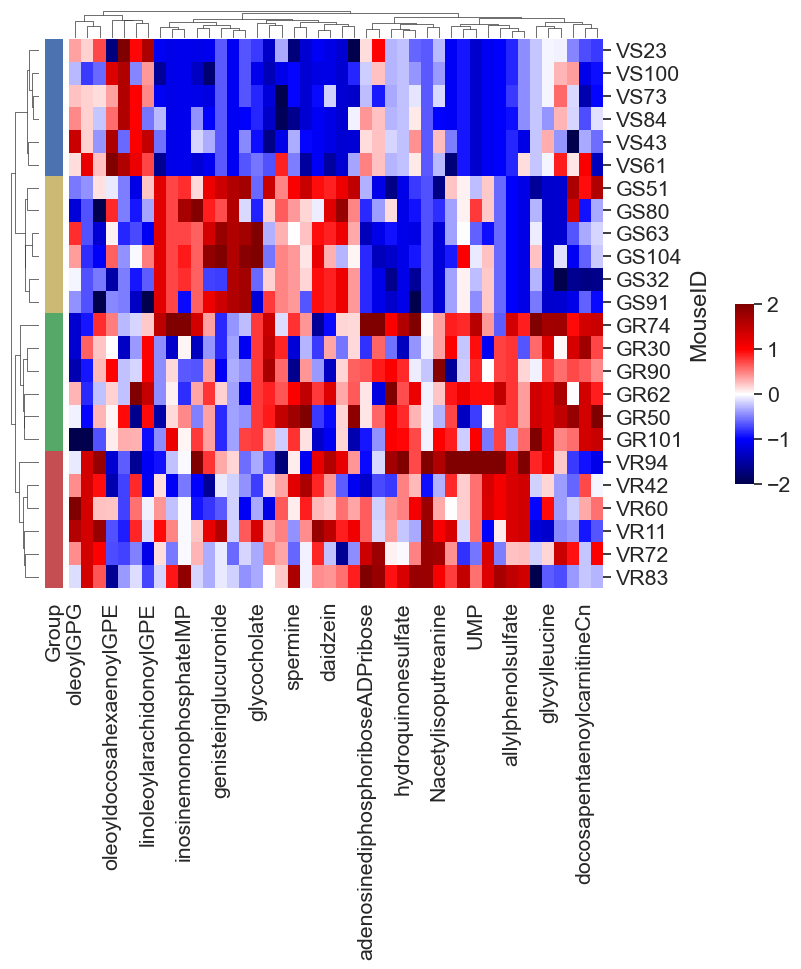

In [209]:
lut = dict(zip(serum_DE.Group.unique(), "rbgy"))
row_colours =  serum_DE.Group.map(lut)
sns.set(font_scale=1.4)
sns.clustermap(serum_DE.select_dtypes(include=np.number),row_colors=row_colours,cmap='seismic',method='complete',metric='seuclidean',
               dendrogram_ratio=0.05, cbar_pos=(1,0.5,0.025,0.18),figsize=(7.5,10),vmin=-2,vmax=2,center=0)

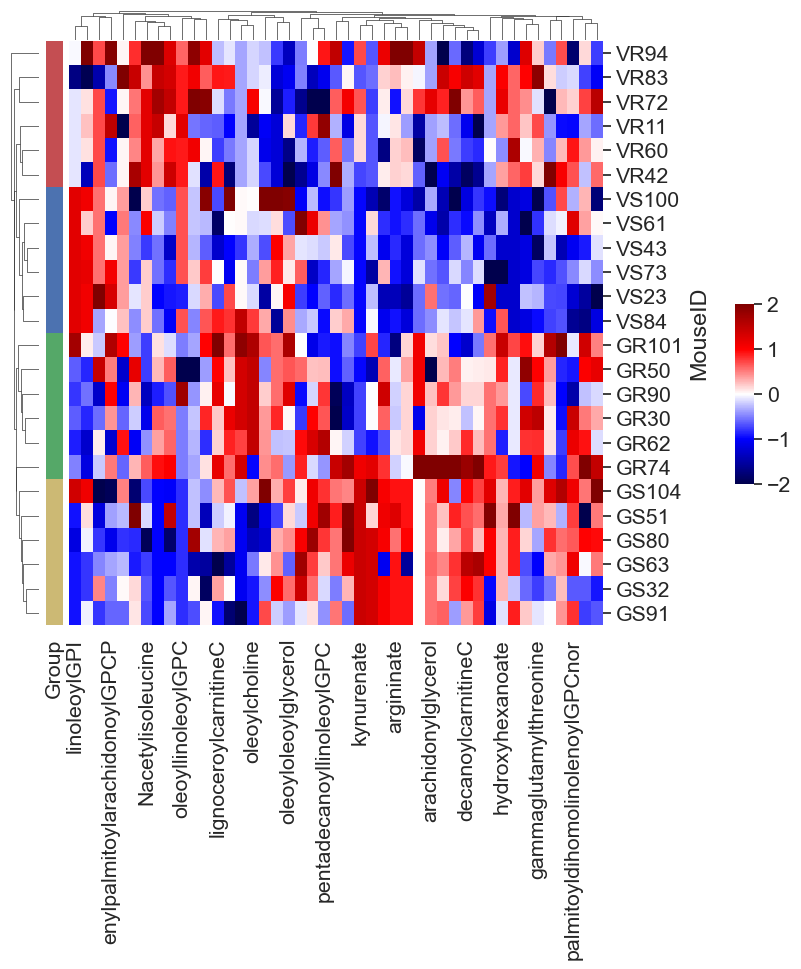

In [210]:
lut = dict(zip(muscle_DE.Group.unique(), "rbgy"))
row_colours =  muscle_DE.Group.map(lut)
sns.set(font_scale=1.4)
sns.clustermap(muscle_DE.select_dtypes(include=np.number),row_colors=row_colours,cmap='seismic',method='average',metric='seuclidean',
               dendrogram_ratio=0.05, cbar_pos=(1,0.5,0.025,0.18),figsize=(7.5,10),vmin=-2,vmax=2,center=0)

## Over-representation analysis

In [211]:
from scipy.stats import hypergeom

plan is to take the muscle_DE and serum_DE and check for over-representation of any of the matabolic sub_pathways (e.g. BCAA degradation instead of super_pathway 'amino acid')

Recall the concept: there is a bucket of M balls, consisting of (n) black and (M-n) white balls. We select N balls without replacement, and want to calculate the probability distribution for black ball selection. E.g., what is the probability of selecting at least k balls, gives p value.
For us, in a pool of ~1000 metabolites, ~ 40 are related to BCAA metabolism, if ~ 200 metabolites are differentially abundant, what is the probability that x metabolites from BCAA metabolism are significant? If less than 0.05, ***

can calculate fold enrichment, in form of observed/expected  - > (differentially abundant BCAA / total differentially abundant) / (BCAA/total)

In [212]:
def Over_rep(df,chem_df):
    # plan to take the hit_results df. Find the Metabolite in the chemicals df under NEW_NAME. conduct appropriate enrichment analyses
    hit_set = set(df.Metabolite) # all significant metabolites, i.e. total balls drawn from bucket
    N = len(hit_set)
    M = len(set(chem_df.NEW_NAME)) # all chemicals assessed, i.e. total balls in bucket
    pathways = set(chem_df.SUB_PATHWAY) # all pathways
    scores = pd.DataFrame(columns=['Pathway','Enrichment_Score','p_value'])
    for pathway in pathways:
        metabolite_set = set(chem_df[chem_df.SUB_PATHWAY == pathway]['NEW_NAME']) # total chemicals in pathway of interest, i.e. count of black balls
        match_set = set.intersection(metabolite_set,hit_set) # chemicals in path of interest that are significant, i.e. number of black balls drawn out of bucket
        [k, n] = [len(match_set), len(metabolite_set)]
        # print(pathway,'\n',match_set)
        enrichment_score = (k/N)/(n/M) # fold enrichment
        hg = hypergeom(M, n, N)
        p_value = hg.sf(k) # probability of having this many, or more, hits in the pathway of interest 
        scores.loc[len(scores)] = pd.Series({
            'Pathway':pathway,
            'Enrichment_Score':enrichment_score,
            'p_value':p_value
        })
    return scores

In [213]:
mus_ORA = Over_rep(mus_hit_results[mus_hit_results.Ex == 'R'],sel_chemicals[sel_chemicals.SUPER_PATHWAY == 'Amino Acid'])
mus_ORA.sort_values(by='p_value')

,Pathway,Enrichment_Score,p_value
10,Guanidino and Acetamido Metabolism,0.0,0.151067
2,Phenylalanine Metabolism,0.0,0.280534
6,Creatine Metabolism,0.0,0.280534
1,Glutathione Metabolism,0.0,0.485939
8,Polyamine Metabolism,0.0,0.485939
9,Alanine and Aspartate Metabolism,0.0,0.485939
0,Tryptophan Metabolism,0.579545,0.53563
11,"Glycine, Serine and Threonine Metabolism",0.0,0.566639
7,Glutamate Metabolism,0.0,0.60238
14,"Leucine, Isoleucine and Valine Metabolism",0.455357,0.677225


In [214]:
ser_ORA = Over_rep(ser_hit_results[ser_hit_results.Ex == 'R'],sel_chemicals)
ser_ORA.sort_values(by='p_value').head(20)

,Pathway,Enrichment_Score,p_value
81,Glycogen Metabolism,58.4,0.0
50,Bacterial/Fungal,29.2,0.000274
15,Tetrahydrobiopterin Metabolism,29.2,0.000274
86,Phosphatidylethanolamine (PE),8.342857,0.001323
42,Dipeptide,11.68,0.002659
77,Primary Bile Acid Metabolism,8.342857,0.005474
75,"Fatty Acid Metabolism (Acyl Carnitine, Polyuns...",7.3,0.007226
71,"Fatty Acid Metabolism (Acyl Carnitine, Monouns...",6.488889,0.009199
44,Short Chain Fatty Acid,0.0,0.017123
100,Purine and Pyrimidine Metabolism,0.0,0.017123


In [201]:
M = 217
N = 40
n = 28
k = 13


hg = hypergeom(M,n,N)
hg.sf(k)

3.882417464114546e-05